# Programming Workflow Calculating EPR – NRC Chignecto

---

**Lab**: In_coast Lab  
**Author**: C. Hart  
**Date**: 2024-09-12  

Notebook that processes and analyzes data from abmur to calculte end point erosion rate EPR

---

In [6]:
%%capture
# ^Command to not print anything from this cell -- makes notebook less messy sometimes
# Import required modules
import easygui
import pandas as pd
import glob
import os
import sys
import numpy as np
import pyrsktools
from pyrsktools import RSK as RSK
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from datetime import timedelta
import matplotlib.dates as mdates
from matplotlib.ticker import MaxNLocator
from openpyxl import load_workbook
from scipy.fft import fft, ifft
import statsmodels.api as sm
from scipy.signal import welch
import os
import zipfile
import easygui
import matplotlib.gridspec as gridspec
import matplotlib.colors as mcolors
sys.path.append(r'C:\Users\S1495478\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\hoboreader')

In [142]:
# Declare paths
shore_pts_path_dbf = r"C:\Users\S1495478\Documents\RBR\NRC\Delft3d\AMBUR_capture\2024-09-11 17_57_07.371334 shorepts\shore_pts.dbf"
shore_pts_path_shp = r"C:\Users\S1495478\Documents\RBR\NRC\Delft3d\AMBUR_capture\2024-09-11 17_57_07.371334 shorepts\shore_pts.shp"
perp_transects_path_dbf = r"C:\Users\S1495478\Documents\RBR\NRC\Delft3d\NB_Lidar\AMBUR_transects\2024-09-11 17_56_15.031009 transects\perp_transects.shp"
perp_transects_path_shp = r"C:\Users\S1495478\Documents\RBR\NRC\Delft3d\NB_Lidar\AMBUR_transects\2024-09-11 17_56_15.031009 transects\perp_transects.dbf"

Error reading shapefile: C:\Users\S1495478\Documents\RBR\NRC\Delft3d\AMBUR_capture\2024-09-11 17_57_07.371334 shorepts\shore_pts.shp: No such file or directory
Error reading DBF file: could not find file 'C:\\Users\\S1495478\\Documents\\RBR\\NRC\\Delft3d\\AMBUR_capture\\2024-09-11 17_57_07.371334 shorepts\\shore_pts.dbf'
Shapefile loaded successfully:
    Id  Transect  TranSpace  TranDist Location  MaxBNum  BaseOrder  OFFshore  \
0  1.0       1.0       25.0     500.0     None      0.0        1.0       1.0   
1  2.0       2.0       25.0     500.0     None      0.0        1.0       1.0   
2  3.0       3.0       25.0     500.0     None      0.0        1.0       1.0   
3  4.0       4.0       25.0     500.0     None      0.0        1.0       1.0   
4  5.0       5.0       25.0     500.0     None      0.0        1.0       1.0   

   CastDir BASE_LOC         StartX        StartY           EndX          EndY  \
0     -1.0     None  397614.172189  5.080161e+06  397114.877089  5.080134e+06   
1  

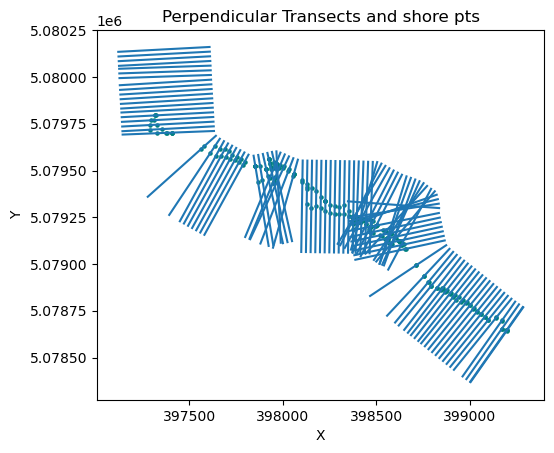

In [144]:
# import files into dataframes and inspect them

# import shore pts files into dataframes and inspect them
import geopandas as gpd
import pandas as pd
from dbfread import DBF

# Paths to the files
shore_pts_path_dbf = r"C:\Users\S1495478\Documents\RBR\NRC\Delft3d\AMBUR_capture\2024-09-11 17_57_07.371334 shorepts\shore_pts.dbf"
shore_pts_path_shp = r"C:\Users\S1495478\Documents\RBR\NRC\Delft3d\AMBUR_capture\2024-09-11 17_57_07.371334 shorepts\shore_pts.shp"

# Read the shapefile into a GeoDataFrame
try:
    shore_pts_gdf = gpd.read_file(shore_pts_path_shp)
    print("Shapefile loaded successfully:")
    # print(shore_pts_gdf.head())
except Exception as e:
    print(f"Error reading shapefile: {e}")

# Read the .dbf file into a DataFrame
try:
    shore_pts_dbf = pd.DataFrame(iter(DBF(shore_pts_path_dbf)))
    print("DBF file loaded successfully:")
    # print(shore_pts_dbf.head())
except Exception as e:
    print(f"Error reading DBF file: {e}")

# Read the shapefile into a GeoDataFrame
try:
    perp_transects_gdf = gpd.read_file(perp_transects_path_shp)
    print("Shapefile loaded successfully:")
    print(perp_transects_gdf.head())
except Exception as e:
    print(f"Error reading shapefile: {e}")

# Read the DBF file into a DataFrame
try:
    perp_transects_dbf = pd.DataFrame(iter(DBF(perp_transects_path_dbf)))
    print("DBF file loaded successfully:")
    print(perp_transects_dbf.head())
except Exception as e:
    print(f"Error reading DBF file: {e}")

# Plotting the shapefile data
try:
    perp_transects_gdf.plot()
    plt.title('Perpendicular Transects and shore pts')
    plt.xlabel('X')
    plt.ylabel('Y')

    plt.scatter(shore_pts_gdf['POINT_X'], shore_pts_gdf['POINT_Y'], c='teal', s=5)
    # plt.colorbar()
    plt.show()

    plt.show()
except Exception as e:
    print(f"Error plotting shapefile: {e}")



In [128]:
import numpy as np
from shapely.geometry import Point

buffered_transects_gdf = perp_transects_gdf.copy()
buffered_transects_gdf['geometry'] = buffered_transects_gdf.geometry.buffer(0.01)  # Buffer by 1 cm to avoid rounding errors

transects = 0
distances = 0

# Function to calculate Euclidean distance between two points using Pythagoras theorem
def calculate_distance(point1, point2):
    delta_x = point2.x - point1.x
    delta_y = point2.y - point1.y
    distance = np.sqrt(delta_x**2 + delta_y**2)
    return distance

# Function to count points on each transect and calculate distance if exactly 2 points are found
def process_transect(transect, shore_pts_gdf):
    # Filter points that intersect the transect
    points_on_transect = shore_pts_gdf[shore_pts_gdf.geometry.intersects(transect.geometry)]
    
    if len(points_on_transect) == 2:
        point1 = points_on_transect.geometry.iloc[0]
        point2 = points_on_transect.geometry.iloc[1]
        distance = calculate_distance(point1, point2)
        print(f"Transect {transect.name}: Distance between two points = {distance:.2f} units")
        return distance
    else:
        print(f"Transect {transect.name}: {len(points_on_transect)} points found")
        return 0   


# Iterate through each transect and check for exactly two points
for i, transect in buffered_transects_gdf.iterrows():
    distances = distances + process_transect(transect, shore_pts_gdf)
    if process_transect(transect, shore_pts_gdf) > 0:
        transects = transects + 1    

print(f"EPR = {distances/transects/5} over {transects} transects")

Transect 0: 0 points found
Transect 0: 0 points found
Transect 1: 0 points found
Transect 1: 0 points found
Transect 2: 0 points found
Transect 2: 0 points found
Transect 3: 0 points found
Transect 3: 0 points found
Transect 4: 0 points found
Transect 4: 0 points found
Transect 5: 0 points found
Transect 5: 0 points found
Transect 6: 0 points found
Transect 6: 0 points found
Transect 7: 0 points found
Transect 7: 0 points found
Transect 8: 0 points found
Transect 8: 0 points found
Transect 9: 0 points found
Transect 9: 0 points found
Transect 10: 0 points found
Transect 10: 0 points found
Transect 11: 0 points found
Transect 11: 0 points found
Transect 12: 0 points found
Transect 12: 0 points found
Transect 13: 0 points found
Transect 13: 0 points found
Transect 14: 3 points found
Transect 14: 3 points found
Transect 15: Distance between two points = 19.69 units
Transect 15: Distance between two points = 19.69 units
Transect 16: Distance between two points = 37.28 units
Transect 16: Di

C:\Users\S1495478\AppData\Local\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


AttributeError: The CRS attribute of a GeoDataFrame without an active geometry column is not defined. Use GeoDataFrame.set_geometry to set the active geometry column.

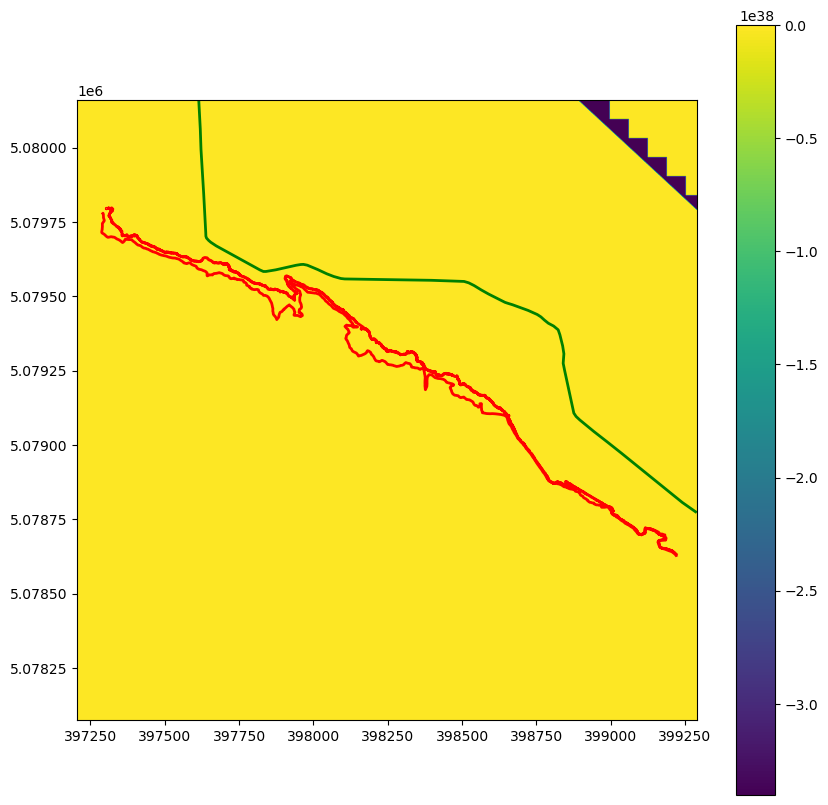

In [332]:
import geopandas as gpd
import rasterio
import numpy as np
import matplotlib.pyplot as plt

# Function to display raster and overlay polylines and transects
def display_raster_with_polylines(raster_path, polyline_path1, polyline_path2, perp_transects_gdf):
    # Open and display the raster file
    with rasterio.open(raster_path) as dataset:
        raster_data = dataset.read(1)

        # Plot the raster using imshow
        fig, ax = plt.subplots(figsize=(10, 10))

        raster_mean = np.nanmean(raster_data)
        raster_data = np.where(np.isnan(raster_data), raster_mean, raster_data)

        img = ax.imshow(raster_data, cmap='viridis', extent=(dataset.bounds.left, dataset.bounds.right, dataset.bounds.bottom, dataset.bounds.top))

        # Add a colorbar
        plt.colorbar(img, ax=ax)

        # Import and plot the first polyline (dyke)
        polyline1 = gpd.read_file(polyline_path1)
        polyline1.plot(ax=ax, edgecolor='green', linewidth=2, label='Dyke')  # Adjust color and line width as needed

        # Import and plot the second polyline (shoreline)
        polyline2 = gpd.read_file(polyline_path2)
        polyline2.plot(ax=ax, edgecolor='red', linewidth=2, label='Shoreline')  # Adjust color and line width as needed

        # Plot the transects
        perp_transects_gdf.plot(ax=ax, edgecolor='blue', linewidth=1, linestyle='--', label='Transects')  # Adjust style and color as needed

        # Set x and y axis limits based on raster bounds or manually
        plt.xlim(dataset.bounds.left, dataset.bounds.right)  # Modify as needed for custom limits
        plt.ylim(dataset.bounds.bottom, dataset.bounds.top)  # Modify as needed for custom limits

        # Set plot labels and legend
        plt.xlabel('X')
        plt.ylabel('Y')
        plt.legend()

        # Display the plot
        plt.show()

# File paths
raster_path = r"C:\Users\S1495478\Documents\ArcGIS\Projects\20240904_AUL\c20210801_Aulac_Lidar_D_C.tif"
shoreline_path_shp = r"C:\Users\S1495478\Documents\RBR\NRC\Delft3d\ambur_Contour_Merge.shp"
dyke_path_shp = r"C:\Users\S1495478\Documents\RBR\NRC\Delft3d\NB_Lidar\DYKE2.shp"

# Example GeoDataFrame for transects (replace this with actual data)
# perp_transects_gdf = gpd.read_file("path_to_your_transects.shp")
# For example:
perp_transects_gdf = gpd.GeoDataFrame()  # Replace with your actual transects GeoDataFrame

# Display the raster with polylines and transects
display_raster_with_polylines(raster_path, dyke_path_shp, shoreline_path_shp, perp_transects_gdf)

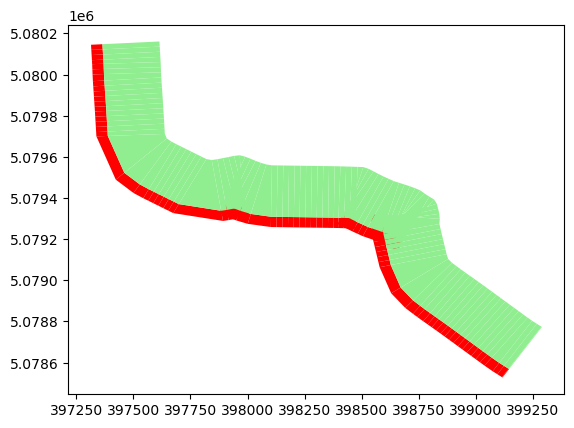

In [322]:

# Initialize lists to store all x and y coordinates for the single polygon
x_coords = []
y_coords = []

dis1 = 0
dis2 = 250
dis3 = 300


# Loop through the DataFrame and collect the x and y coordinates
for i in range(0,len(MarshWidth)-1):

    xc = []
    yc = []

    xe = []
    ye = []
    
    xc.append(MarshWidth['x'+ str(dis1)][i])
    xc.append(MarshWidth['x'+ str(dis1)][i+1])
    xc.append(MarshWidth['x'+ str(dis2)][i+1])
    xc.append(MarshWidth['x'+ str(dis2)][i])
    
    yc.append(MarshWidth['y'+ str(dis1)][i])
    yc.append(MarshWidth['y'+ str(dis1)][i+1])
    yc.append(MarshWidth['y'+ str(dis2)][i+1])
    yc.append(MarshWidth['y'+ str(dis2)][i])

    xe.append(MarshWidth['x'+ str(dis2)][i])
    xe.append(MarshWidth['x'+ str(dis2)][i+1])
    xe.append(MarshWidth['x'+ str(dis3)][i+1])
    xe.append(MarshWidth['x'+ str(dis3)][i])
    
    ye.append(MarshWidth['y'+ str(dis2)][i])
    ye.append(MarshWidth['y'+ str(dis2)][i+1])
    ye.append(MarshWidth['y'+ str(dis3)][i+1])
    ye.append(MarshWidth['y'+ str(dis3)][i])
    
    plt.fill(xe, ye, color="red", alpha=1, edgecolor='none')
    
for i in range(0,len(MarshWidth)-1):
    xc = []
    yc = []

    xe = []
    ye = []
    
    xc.append(MarshWidth['x'+ str(dis1)][i])
    xc.append(MarshWidth['x'+ str(dis1)][i+1])
    xc.append(MarshWidth['x'+ str(dis2)][i+1])
    xc.append(MarshWidth['x'+ str(dis2)][i])
    
    yc.append(MarshWidth['y'+ str(dis1)][i])
    yc.append(MarshWidth['y'+ str(dis1)][i+1])
    yc.append(MarshWidth['y'+ str(dis2)][i+1])
    yc.append(MarshWidth['y'+ str(dis2)][i])

    xe.append(MarshWidth['x'+ str(dis2)][i])
    xe.append(MarshWidth['x'+ str(dis2)][i+1])
    xe.append(MarshWidth['x'+ str(dis3)][i+1])
    xe.append(MarshWidth['x'+ str(dis3)][i])
    
    ye.append(MarshWidth['y'+ str(dis2)][i])
    ye.append(MarshWidth['y'+ str(dis2)][i+1])
    ye.append(MarshWidth['y'+ str(dis3)][i+1])
    ye.append(MarshWidth['y'+ str(dis3)][i])
    plt.fill(xc, yc, color="lightgreen", alpha=1, edgecolor='none')


# # Close the polygon by connecting the last point back to the first point
# x_coords.append(MarshWidth['x0'][0])
# y_coords.append(MarshWidth['y0'][0])

# # Plot the single polygon with many vertices
# # plt.plot(x_coords, y_coords, marker='o')

# # plt.xlabel('X Coordinates')
# # plt.ylabel('Y Coordinates')
# # plt.title('Single Polygon with Multiple Vertices')
# # plt.show()

# # Plot the polygon enclosing the points
# if len(x_coords) > 0:
#     # Create a list of Shapely Point objects from the coordinates
#     points = MultiPoint([(x, y) for x, y in zip(x_coords, y_coords)])
    
#     # Get the convex hull (polygon) of the points
#     if points.convex_hull.geom_type == 'Polygon':
#         hull = points.convex_hull
#     else:
#         print("Not enough points to form a polygon")
#         hull = None
    
#     if hull:
#         # Extract the coordinates of the convex hull polygon
#         hull_coords = np.array(hull.exterior.coords)
        
#         # Plot the points and the convex hull polygon
#         plt.figure(figsize=(10, 8))
#         plt.plot(x_coords, y_coords, 'o', markersize=5, label="Points")
#         plt.plot(hull_coords[:, 0], hull_coords[:, 1], color='blue', label="Polygon Hull")
#         plt.fill(hull_coords[:, 0], hull_coords[:, 1], color='lightblue', alpha=0.5)
        
#         plt.xlabel('X coordinate')
#         plt.ylabel('Y coordinate')
#         plt.title('Polygon Enclosing Points on Transects with Exactly 2 Points')
#         plt.legend()
#         plt.grid(True)
#         plt.show()

In [252]:
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import MultiPoint, Polygon
from scipy.spatial import Delaunay
import alphashape

# Assuming MarshWidth DataFrame is available

# Collect x and y coordinates
x_coords = []
y_coords = []

for i in range(len(MarshWidth)):
    x_coords.append(MarshWidth['x0'][i])
    y_coords.append(MarshWidth['y0'][i])
    x_coords.append(MarshWidth['x100'][i])
    y_coords.append(MarshWidth['y100'][i])
    
    plt.fill(x_coords, y_coords, color='lightblue', alpha=0.5)


# Close the polygon by connecting the last point back to the first point
x_coords.append(MarshWidth['x0'][0])
y_coords.append(MarshWidth['y0'][0])

# Convert to MultiPoint
# points = MultiPoint([(x, y) for x, y in zip(x_coords, y_coords)])
points = [(x, y) for x, y in zip(x_coords, y_coords)]


# Alpha shape algorithm
alpha = 0.1  # adjust alpha value as needed
alpha_shape = alphashape.alphashape(points, alpha)

# Check if alpha_shape is a polygon
# if alpha_shape.geom_type == 'Polygon':
    
# Loop through each polygon in the MultiPolygon
# for polygon in alpha_shape:
#     # Extract the exterior coordinates of the polygon
#     exterior_coords = polygon.exterior.coords
#     # Loop through the exterior coordinates and separate x and y
#     for coord in exterior_coords:
#         x_coords.append(coord[0])
#         y_coords.append(coord[1])


# Plot the points and the alpha shape polygon
plt.figure(figsize=(10, 8))
plt.plot(x_coords, y_coords, 'o', markersize=5, label="Points")
plt.fill(x_coords, y_coords, color='lightblue', alpha=0.5)

# plt.plot(hull_coords[:, 0], hull_coords[:, 1], color='blue', label="Alpha Shape Hull")
# plt.fill(hull_coords[:, 0], hull_coords[:, 1], color='lightblue', alpha=0.5)

plt.xlabel('X coordinate')
plt.ylabel('Y coordinate')
plt.title('Polygon Enclosing Points (Alpha Shape)')
plt.legend()
plt.grid(True)
plt.show()

# else:
#     print("No polygon could be formed with the given alpha value.")

TypeError: 'MultiPolygon' object is not iterable

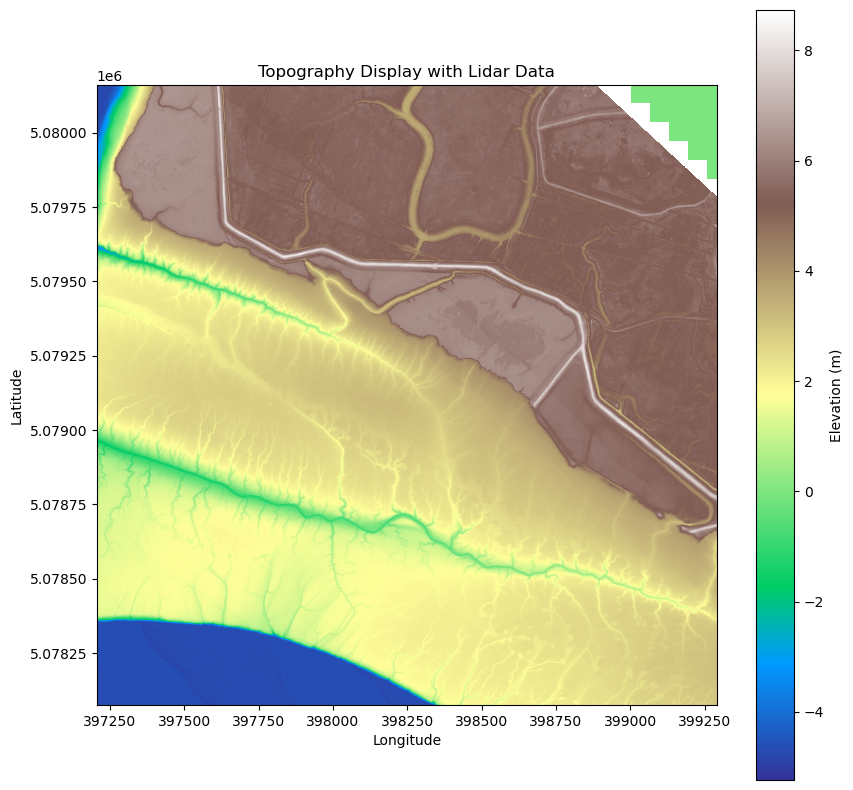

In [346]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt

# Path to your file
file_path = r"C:\Users\S1495478\Documents\ArcGIS\Projects\20240904_AUL\c20210801_Aulac_Lidar_D_C.tif"

# Open the GeoTIFF file
with rasterio.open(file_path) as src:
    # Read the data from the first band
    data = src.read(1)
    
    # Masking out invalid data values, assuming values like np.nan or very high/low numbers indicate no data
    data = np.ma.masked_where(data <= -1e10, data)  # You can change the threshold based on your data
    
    # Calculate the extent manually
    extent = (src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top)
    
    # Plot the data
    plt.figure(figsize=(10, 10))
    plt.imshow(data, cmap='terrain', extent=extent)
    plt.colorbar(label='Elevation (m)')

    
    # Import and plot the first polyline (dyke)
    polyline1 = gpd.read_file(dyke_path_shp)
    polyline1.plot(ax=ax, edgecolor='green', linewidth=12, label='Dyke')  # Adjust color and line width as needed

    # # Import and plot the second polyline (shoreline)
    # polyline2 = gpd.read_file(dyke_path_shp)
    # polyline2.plot(ax=ax, edgecolor='red', linewidth=2, label='Shoreline')  # Adjust color and line width as needed

    
    # Adding axis labels (adjust based on the coordinate system of your data)
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title('Topography Display with Lidar Data')
    
    plt.show()

ValueError: Do not know how to convert array([2]) to dashes

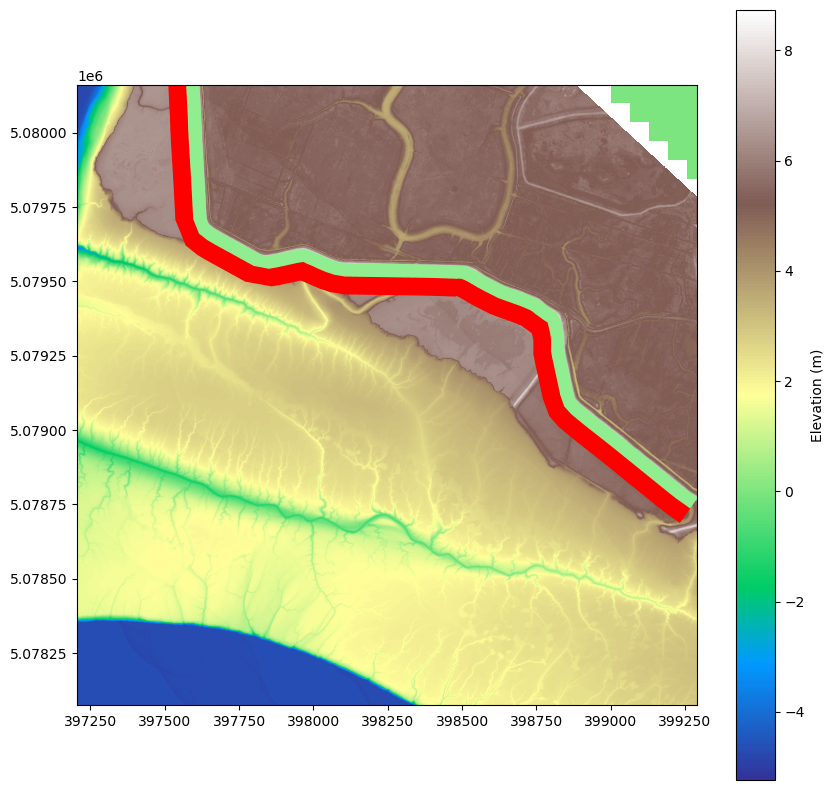

In [386]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd

# Path to your files
file_path = r"C:\Users\S1495478\Documents\ArcGIS\Projects\20240904_AUL\c20210801_Aulac_Lidar_D_C.tif"
shoreline_path_shp = r"C:\Users\S1495478\Documents\RBR\NRC\Delft3d\Contour_20210801.shp"
dyke_path_shp = r"C:\Users\S1495478\Documents\RBR\NRC\Delft3d\NB_Lidar\DYKE2.shp"

dis1 = 0
dis2 = 40
dis3 = 100

# Open the GeoTIFF file
with rasterio.open(file_path) as src:
    # Read the data from the first band
    data = src.read(1)
    
    # Masking out invalid data values, assuming values like np.nan or very high/low numbers indicate no data
    data = np.ma.masked_where(data <= -1e10, data)  # You can change the threshold based on your data
    
    # Calculate the extent manually
    extent = (src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top)
    
    # Create the figure and axis
    fig, ax = plt.subplots(figsize=(10, 10))
    
    # Plot the raster data
    raster_image = ax.imshow(data, cmap='terrain', extent=extent)
    plt.colorbar(raster_image, ax=ax, label='Elevation (m)')
    
    # Loop through the DataFrame and collect the x and y coordinates
    for i in range(0,len(MarshWidth)-1):
    
        xc = []
        yc = []
    
        xe = []
        ye = []
        
        xc.append(MarshWidth['x'+ str(dis1)][i])
        xc.append(MarshWidth['x'+ str(dis1)][i+1])
        xc.append(MarshWidth['x'+ str(dis2)][i+1])
        xc.append(MarshWidth['x'+ str(dis2)][i])
        
        yc.append(MarshWidth['y'+ str(dis1)][i])
        yc.append(MarshWidth['y'+ str(dis1)][i+1])
        yc.append(MarshWidth['y'+ str(dis2)][i+1])
        yc.append(MarshWidth['y'+ str(dis2)][i])
    
        xe.append(MarshWidth['x'+ str(dis2)][i])
        xe.append(MarshWidth['x'+ str(dis2)][i+1])
        xe.append(MarshWidth['x'+ str(dis3)][i+1])
        xe.append(MarshWidth['x'+ str(dis3)][i])
        
        ye.append(MarshWidth['y'+ str(dis2)][i])
        ye.append(MarshWidth['y'+ str(dis2)][i+1])
        ye.append(MarshWidth['y'+ str(dis3)][i+1])
        ye.append(MarshWidth['y'+ str(dis3)][i])
        
        plt.fill(xe, ye, color="red", alpha=1, edgecolor='red')
        if i == len(MarshWidth)-2: plt.fill(xe, ye, color="red", alpha=1, edgecolor='red', label='Erosion')
        
    for i in range(0,len(MarshWidth)-1):
        xc = []
        yc = []
    
        xe = []
        ye = []
        
        xc.append(MarshWidth['x'+ str(dis1)][i])
        xc.append(MarshWidth['x'+ str(dis1)][i+1])
        xc.append(MarshWidth['x'+ str(dis2)][i+1])
        xc.append(MarshWidth['x'+ str(dis2)][i])
        
        yc.append(MarshWidth['y'+ str(dis1)][i])
        yc.append(MarshWidth['y'+ str(dis1)][i+1])
        yc.append(MarshWidth['y'+ str(dis2)][i+1])
        yc.append(MarshWidth['y'+ str(dis2)][i])
    
        xe.append(MarshWidth['x'+ str(dis2)][i])
        xe.append(MarshWidth['x'+ str(dis2)][i+1])
        xe.append(MarshWidth['x'+ str(dis3)][i+1])
        xe.append(MarshWidth['x'+ str(dis3)][i])
        
        ye.append(MarshWidth['y'+ str(dis2)][i])
        ye.append(MarshWidth['y'+ str(dis2)][i+1])
        ye.append(MarshWidth['y'+ str(dis3)][i+1])
        ye.append(MarshWidth['y'+ str(dis3)][i])
        plt.fill(xc, yc, color="lightgreen", alpha=1, edgecolor='lightgreen')
        if i == len(MarshWidth)-2: plt.fill(xc, yc, color="lightgreen", alpha=1, edgecolor='lightgreen', label='Marsh Width')
      
    
    # Import and plot the first polyline (dyke)
    polyline1 = gpd.read_file(dyke_path_shp)
    polyline1.plot(ax=ax, edgecolor='pink', linewidth=2, label='Dyke', dashes=[2])  # Adjust color and line width as needed

    # Import and plot the second polyline (shoreline 2021)
    polyline1 = gpd.read_file(shoreline_path_shp)
    polyline1.plot(ax=ax, edgecolor='black', linewidth=1, label='Shoreline 2021')  # Adjust color and line width as needed
    
    # Adding axis labels (adjust based on the coordinate system of your data)
    ax.set_xlabel('Y')
    ax.set_ylabel('X')
    ax.set_title('Aulac Topography 2021')
    
    plt.legend()
    plt.show()